In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn 
import torch.nn.functional as F

class RRCGDDataset(Dataset):
    def __init__(self, rrcgd_dir, label_dir):
        self.files = sorted([
            f for f in os.listdir(rrcgd_dir)
            if f.endswith("_rrcgd.npy")
        ])
        self.rrcgd_dir = rrcgd_dir
        self.label_dir = label_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        rrcgd_path = os.path.join(self.rrcgd_dir, self.files[idx])
        label_path = os.path.join(
            self.label_dir,
            self.files[idx].replace("_rrcgd.npy", ".npy")
        )

        X = np.load(rrcgd_path)              # (T, 256)
        X = X[:, :256]                   # keep fs/4
        y_hz = np.load(label_path)        # (T,)

        y = hz_to_bin(y_hz)                  # (T,)
        return torch.from_numpy(X), torch.from_numpy(y)

In [2]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    Xs, Ys = zip(*batch)

    lengths = torch.tensor([x.shape[0] for x in Xs])

    Xs = pad_sequence(Xs, batch_first=True)  # (B, T, 256)
    Ys = pad_sequence(Ys, batch_first=True)  # (B, T)

    mask = (Ys != 0).float()                 # voiced mask

    return Xs, Ys, mask, lengths

In [3]:
import numpy as np
import torch
import mir_eval

F_REF = 55.0
C_MIN = -1200.0
CENTS_PER_BIN = 20.0
def bin_to_hz(bins: np.ndarray):
    """
    bins: (T,) int, 0 = unvoiced
    returns: (T,) float Hz, 0 = unvoiced
    """
    hz = np.zeros_like(bins, dtype=np.float32)
    voiced = bins > 0

    cents = C_MIN + bins[voiced] * CENTS_PER_BIN
    hz[voiced] = F_REF * (2.0 ** (cents / 1200.0))
    return hz

In [4]:
def compute_metrics_mir_eval(logits, targets):
    """
    logits:  (B, T, K)
    targets: (B, T), bin labels, 0 = unvoiced
    returns: dict with mir_eval metrics (averaged over batch)
    """
    logits = logits.detach().cpu()
    targets = targets.detach().cpu()

    B = logits.shape[0]

    metrics_sum = {
        "VRR": 0.0,
        "RPA": 0.0,
        "RCA": 0.0,
        "OA": 0.0,
    }

    for b in range(B):
        pred_bins = torch.argmax(logits[b], dim=-1).numpy()
        gt_bins   = targets[b].numpy()

        pred_hz = bin_to_hz(pred_bins)
        gt_hz   = bin_to_hz(gt_bins)

        scores = mir_eval.melody.evaluate(
            ref_time=np.arange(len(gt_hz)),
            ref_freq=gt_hz,
            est_time=np.arange(len(pred_hz)),
            est_freq=pred_hz,
        )

        metrics_sum["VRR"] += scores["Voicing Recall"]
        metrics_sum["RPA"] += scores["Raw Pitch Accuracy"]
        metrics_sum["RCA"] += scores["Raw Chroma Accuracy"]
        metrics_sum["OA"]  += scores["Overall Accuracy"]

    for k in metrics_sum:
        metrics_sum[k] /= B

    return metrics_sum

In [5]:
def masked_ce_loss(logits, targets, mask):
    B, T, C = logits.shape

    ce = F.cross_entropy(
        logits.view(-1, C),
        targets.view(-1),
        reduction="none"
    ).view(B, T)

    loss = (ce * mask).sum() / (mask.sum() + 1e-8)
    return loss


In [115]:
import torch
import torch.nn.functional as F

def pitch_smoothed_ce_loss(
    logits,
    targets,
    mask,
    sigma=1.0
):
    """
    logits : (B,T,K)
    targets: (B,T) integer bins
    mask   : (B,T) voiced mask
    """

    B, T, K = logits.shape
    device = logits.device

    # Create bin index tensor
    bins = torch.arange(K, device=device).view(1, 1, K)

    # Expand targets
    tgt = targets.unsqueeze(-1)

    # Gaussian smoothing
    smooth_targets = torch.exp(
        -0.5 * ((bins - tgt) / sigma) ** 2
    )

    # Zero-out unvoiced
    smooth_targets = smooth_targets * mask.unsqueeze(-1)

    # Normalize
    smooth_targets = smooth_targets / (
        smooth_targets.sum(dim=-1, keepdim=True) + 1e-8
    )

    log_probs = F.log_softmax(logits, dim=-1)
    loss = -(smooth_targets * log_probs).sum(dim=-1)

    return loss.sum() / (mask.sum() + 1e-8)

In [6]:
# Normal CE weighted loss
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for X, Y, mask, _ in loader:
        X = X.to(device)
        Y = Y.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        logits = model(X)              # (B, T, K)
        loss = masked_ce_loss(logits, Y, mask)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [117]:
# Pitch smoothed CE weighted loss
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for X, Y, mask, _ in loader:
        X = X.to(device)
        Y = Y.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        logits = model(X)              # (B, T, K)
        loss = pitch_smoothed_ce_loss(logits, Y, mask)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [7]:
def bin_to_hz(bin_idx):
    """
    bin_idx: (T,) int, 0 = unvoiced
    returns: (T,) float Hz
    """
    bin_idx = np.asarray(bin_idx)
    hz = np.zeros_like(bin_idx, dtype=np.float32)

    voiced = bin_idx > 0
    cents = C_MIN + bin_idx[voiced] * CENTS_PER_BIN
    hz[voiced] = F_REF * (2.0 ** (cents / 1200.0))

    return hz

In [8]:
import numpy as np

F_REF = 55.0
C_MIN = -1200.0
CENTS_PER_BIN = 20.0
N_BINS = 360        # including bin 0 = unvoiced

def hz_to_bin(f0_hz):
    """
    f0_hz: (T,) array-like, Hz, 0 = unvoiced
    returns: (T,) int bins, 0 = unvoiced
    """
    f0_hz = np.asarray(f0_hz)
    bins = np.zeros_like(f0_hz, dtype=np.int64)

    voiced = f0_hz > 0
    cents = 1200.0 * np.log2(f0_hz[voiced] / F_REF)

    bins_voiced = np.floor((cents - C_MIN) / CENTS_PER_BIN).astype(np.int64)
    bins_voiced = np.clip(bins_voiced, 1, N_BINS - 1)

    bins[voiced] = bins_voiced
    return bins

In [9]:
def voiced_mask_from_target(y):
    return y > 0   # bin 0 = unvoiced


In [118]:
def validate_with_loss(model, loader, device):
    model.eval()
    total_loss = 0.0
    n = 0

    with torch.no_grad():
        for X, Y, mask, _ in loader:
            X = X.to(device)
            Y = Y.to(device)
            mask = mask.to(device)

            logits = model(X)                 # (B, T, K)
            loss = pitch_smoothed_ce_loss(logits, Y, mask)

            total_loss += loss.item()
            n += 1

    return total_loss / n

In [11]:
import torch
import mir_eval

def evaluate_full(model, loader, device):
    model.eval()

    metrics_sum = {
        "VRR": 0.0,
        "RPA": 0.0,
        "RCA": 0.0,
        "OA":  0.0,
    }
    n_seq = 0

    with torch.no_grad():
        for X, Y, _, lengths in loader:
            X = X.to(device)
            Y = Y.to(device)

            logits = model(X)  # (B, T, K)
            preds = torch.argmax(logits, dim=-1)  # (B, T)

            B = X.shape[0]

            for b in range(B):
                T = lengths[b].item()

                gt_bins   = Y[b, :T].cpu().numpy()
                pred_bins = preds[b, :T].cpu().numpy()

                gt_hz   = bin_to_hz(gt_bins)
                pred_hz = bin_to_hz(pred_bins)

                # dummy time axis (mir_eval only needs alignment)
                t = np.arange(T)

                scores = mir_eval.melody.evaluate(
                    ref_time=t,
                    ref_freq=gt_hz,
                    est_time=t,
                    est_freq=pred_hz,
                )

                metrics_sum["VRR"] += scores["Voicing Recall"]
                metrics_sum["RPA"] += scores["Raw Pitch Accuracy"]
                metrics_sum["RCA"] += scores["Raw Chroma Accuracy"]
                metrics_sum["OA"]  += scores["Overall Accuracy"]

                n_seq += 1

    for k in metrics_sum:
        metrics_sum[k] /= max(n_seq, 1)

    return metrics_sum

In [12]:
class BiGRU(nn.Module):
    def __init__(self, input_features, hidden_features, num_layers):
        super(BiGRU, self).__init__()
        self.gru = nn.GRU(input_features, hidden_features, num_layers=num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        return self.gru(x)[0]


class BiLSTM(nn.Module):
    def __init__(self, input_features, hidden_features, num_layers):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_features, hidden_features, num_layers=num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        return self.lstm(x)[0]

### Run from here for experiment

In [13]:
print ("a")

a


In [119]:
del model
del optimizer
del train_loader
del val_loader

In [122]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [123]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [124]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 4090
NVIDIA GeForce RTX 4090


In [125]:
from torch.utils.data import DataLoader, random_split

rrcgd_dir = "dataset/whole_data/train/rrcgd"
label_dir = "dataset/whole_data/train/labels"

dataset = RRCGDDataset(rrcgd_dir, label_dir)

train_ds = RRCGDDataset(
    "dataset/whole_data/train/rrcgd",
    "dataset/whole_data/train/labels"
)
val_ds = RRCGDDataset(
    "dataset/whole_data/val/rrcgd",
    "dataset/whole_data/val/labels"
)
test_ds = RRCGDDataset(
    "dataset/whole_data/test/rrcgd",
    "dataset/whole_data/test/labels"
)
batch_size=16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size, shuffle=False, collate_fn=collate_fn)


In [126]:
# class TemporalResBlock(nn.Module):
#     def __init__(self, ch, dilation):
#         super().__init__()
#         self.block = nn.Sequential(
#             nn.Conv1d(ch, ch, 3, padding=dilation, dilation=dilation),
#             nn.BatchNorm1d(ch),
#             nn.ReLU(),
#             nn.Conv1d(ch, ch, 3, padding=dilation, dilation=dilation),
#             nn.BatchNorm1d(ch),
#         )

#     def forward(self, x):
#         return torch.relu(x + self.block(x))


# class RRCGDNet(nn.Module):
#     def __init__(self, n_bins=360):
#         super().__init__()

#         self.frontend = nn.Sequential(
#             nn.Conv1d(256, 128, 3, padding=1),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             TemporalResBlock(128, dilation=2),
#             TemporalResBlock(128, dilation=4),
#         )

#         self.gru = nn.GRU(
#             input_size=128,
#             hidden_size=192,
#             num_layers=2,
#             batch_first=True,
#             bidirectional=True,
#             dropout=0.2
#         )

#         self.fc = nn.Sequential(
#             nn.Linear(384, 256),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(256, n_bins)
#         )

#     def forward(self, x):
#         # x: (B,T,256)
#         x = x.transpose(1, 2)      # (B,256,T)
#         x = self.frontend(x)
#         x = x.transpose(1, 2)      # (B,T,128)
#         x, _ = self.gru(x)         # (B,T,384)
#         return self.fc(x)

In [127]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

In [128]:
# class ConvBlock(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(in_ch, out_ch, 3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(),
#             nn.Conv2d(out_ch, out_ch, 3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(),
#         )

#     def forward(self, x):
#         return self.block(x)

In [129]:
# class EncoderBlock(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.conv = ConvBlock(in_ch, out_ch)
#         self.pool = nn.MaxPool2d(kernel_size=(2,1))  # ↓ time only

#     def forward(self, x):
#         x = self.conv(x)
#         return x, self.pool(x)

In [130]:
# class DecoderBlock(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.up = nn.ConvTranspose2d(
#             in_ch, out_ch, kernel_size=(2,1), stride=(2,1)
#         )
#         self.conv = ConvBlock(in_ch, out_ch)

#     def forward(self, x, skip):
#         x = self.up(x)
#         x = torch.cat([x, skip], dim=1)
#         return self.conv(x)

In [131]:
# class SimpleUNet(nn.Module):
#     def __init__(self, n_bins=360):
#         super().__init__()

#         # Encoder
#         self.enc1 = nn.Sequential(
#             nn.Conv2d(1, 64, 3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU()
#         )
#         self.enc2 = nn.Sequential(
#             nn.Conv2d(64, 128, 3, stride=(2,1), padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU()
#         )

#         # Bottleneck
#         self.mid = nn.Sequential(
#             nn.Conv2d(128, 256, 3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU()
#         )

#         # Decoder (NOTE channel fix)
#         self.dec1 = nn.Sequential(
#             nn.ConvTranspose2d(256, 128, kernel_size=(2,1), stride=(2,1)),
#             nn.BatchNorm2d(128),
#             nn.ReLU()
#         )

#         self.out = nn.Conv2d(128, 1, 1)

#         # Temporal modeling
#         self.gru = nn.GRU(
#             input_size=256,
#             hidden_size=192,
#             num_layers=2,
#             batch_first=True,
#             bidirectional=True
#         )

#         self.fc = nn.Linear(384, n_bins)

#     def forward(self, x):
#         # x: (B,T,256)
#         x = x.unsqueeze(1).transpose(2,3)   # (B,1,256,T)

#         e1 = self.enc1(x)                    # (B,64,256,T)
#         e2 = self.enc2(e1)                   # (B,128,128,T)
#         m  = self.mid(e2)                    # (B,256,128,T)

#         d1 = self.dec1(m)                    # (B,128,256,T)
#         o  = self.out(d1).squeeze(1)         # (B,256,T)

#         o = o.transpose(1,2)                 # (B,T,256)
#         o,_ = self.gru(o)
#         return self.fc(o)


In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(cin, cout, 3, padding=1),
            nn.BatchNorm2d(cout),
            nn.ReLU(),
            nn.Conv2d(cout, cout, 3, padding=1),
            nn.BatchNorm2d(cout),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.block(x)

In [133]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = ConvBlock(in_ch, out_ch)
        self.pool = nn.AvgPool2d((2,1))

    def forward(self, x):
        s = self.conv(x)
        return s, self.pool(s)


class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=(2,1), stride=(2,1))
        self.conv = ConvBlock(out_ch + skip_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

In [134]:
# #Model 1 

# class RRCGDNet_UNet(nn.Module):
#     def __init__(self, n_bins=300):
#         super().__init__()

#         # Encoder (shallower)
#         self.down1 = Down(1, 64)
#         self.down2 = Down(64, 128)
#         self.down3 = Down(128, 256)

#         # Bottleneck (256 → 256)
#         self.mid = ConvBlock(256, 256)

#         # Decoder
#         self.up3 = Up(256, 256, 128)
#         self.up2 = Up(128, 128, 64)
#         self.up1 = Up(64, 64, 64)

#         self.out_conv = nn.Conv2d(64, 1, 1)

#         # Channel expansion
#         self.expand = nn.Conv1d(256, 512, 1)

#         # Temporal frontend
#         self.temporal = nn.Sequential(
#             nn.Conv1d(512, 512, 3, padding=1),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Conv1d(512, 512, 3, padding=2, dilation=2),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#         )

#         # BiGRU
#         self.gru = nn.GRU(
#             input_size=512,
#             hidden_size=192,
#             num_layers=2,
#             batch_first=True,
#             bidirectional=True,
#             dropout=0.2
#         )

#         self.fc = nn.Linear(384, 360)
#         self.act = nn.Sigmoid()

#     def forward(self, x):
#         # x: (B, T, 256)
#         x = x.unsqueeze(1).transpose(2, 3)  # (B,1,256,T)

#         s1, x = self.down1(x)
#         s2, x = self.down2(x)
#         s3, x = self.down3(x)

#         x = self.mid(x)

#         x = self.up3(x, s3)
#         x = self.up2(x, s2)
#         x = self.up1(x, s1)

#         x = self.out_conv(x).squeeze(1)   # (B,256,T)

#         x = self.expand(x)                # (B,512,T)
#         x = self.temporal(x)              # (B,512,T)

#         x = x.transpose(1, 2)             # (B,T,512)

#         x, _ = self.gru(x)
#         x = self.fc(x)
#         return self.act(x)   # (B, T, 360)

In [135]:
# #model 2
# class RRCGDNet_UNet(nn.Module):
#     def __init__(self, n_bins=360):
#         super().__init__()

#         # ---------------- UNet ----------------
#         self.down1 = Down(1, 64)
#         self.down2 = Down(64, 128)
#         self.down3 = Down(128, 256)
#         self.down4 = Down(256, 512)

#         self.mid = ConvBlock(512, 512)

#         self.up4 = Up(512, 512, 256)
#         self.up3 = Up(256, 256, 128)
#         self.up2 = Up(128, 128, 64)
#         self.up1 = Up(64, 64, 64)

#         self.out_conv = nn.Conv2d(64, 1, 1)

#         # -------- CRITICAL BRIDGE (fs/4 → fs/2 width) --------
#         # Maps 256 frequency bins → 512 channels for temporal frontend
#         self.expand = nn.Conv1d(256, 512, kernel_size=1)

#         # ---------------- Temporal frontend ----------------
#         self.temporal = nn.Sequential(
#             nn.Conv1d(512, 512, 3, padding=1),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Conv1d(512, 512, 3, padding=2, dilation=2),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#         )

#         # ---------------- BiGRU ----------------
#         self.gru = nn.GRU(
#             input_size=512,
#             hidden_size=192,
#             num_layers=2,
#             batch_first=True,
#             bidirectional=True,
#             dropout=0.2
#         )

#         self.fc = nn.Linear(384, n_bins)

#     def forward(self, x):
#         # x: (B, T, 256)
#         x = x.unsqueeze(1).transpose(2, 3)   # (B, 1, 256, T)

#         s1, x = self.down1(x)
#         s2, x = self.down2(x)
#         s3, x = self.down3(x)
#         s4, x = self.down4(x)

#         x = self.mid(x)

#         x = self.up4(x, s4)
#         x = self.up3(x, s3)
#         x = self.up2(x, s2)
#         x = self.up1(x, s1)

#         x = self.out_conv(x).squeeze(1)      # (B, 256, T)

#         # DO NOT transpose here
#         x = self.expand(x)                   # (B, 512, T)
#         x = self.temporal(x)                 # (B, 512, T)

#         x = x.transpose(1, 2)                # (B, T, 512)
#         x, _ = self.gru(x)

#         return self.fc(x)

In [136]:
# #model3 

# class RRCGDNet_UNet(nn.Module):
#     def __init__(self, n_bins=360):
#         super().__init__()

#         # Encoder
#         self.down1 = Down(1, 64)
#         self.down2 = Down(64, 128)
#         self.down3 = Down(128, 256)
#         self.down4 = Down(256,512)

#         # Bottleneck
#         self.mid = ConvBlock(512, 512)

#         # Decoder
#         self.up4 = Up(512,512,256)
#         self.up3 = Up(256, 256, 128)
#         self.up2 = Up(128, 128, 64)
#         self.up1 = Up(64, 64, 64)

#         self.out_conv = nn.Conv2d(64, 1, 1)

#         self.expand = nn.Conv1d(256,512,1)

#         # Temporal frontend
#         # ---- Channel expansion ----
#         self.expand1 = nn.Conv1d(256, 512, kernel_size=1)
#         self.expand2 = nn.Conv1d(512, 1024, kernel_size=1)
        
#         # ---- Temporal blocks ----
#         self.temporal1 = nn.Sequential(
#             nn.Conv1d(512, 512, 3, padding=1),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Conv1d(512, 512, 3, padding=2, dilation=2),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#         )
        
#         self.temporal2 = nn.Sequential(
#             nn.Conv1d(1024, 1024, 3, padding=1),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Conv1d(1024, 1024, 3, padding=2, dilation=2),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#         )


#         self.gru = nn.GRU(
#             input_size=1024,
#             hidden_size=256,
#             num_layers=2,
#             batch_first=True,
#             bidirectional=True,
#             dropout=0.2
#         )
        
#         self.fc = nn.Linear(512, n_bins)
        

#     def forward(self, x):
#         # x: (B, T, 256)
#         x = x.unsqueeze(1).transpose(2, 3)  # (B,1,256,T)

#         s1, x = self.down1(x)
#         s2, x = self.down2(x)
#         s3, x = self.down3(x)
#         s4, x = self.down4(x)

#         x = self.mid(x)

#         x = self.up4(x, s4)
#         x = self.up3(x, s3)
#         x = self.up2(x, s2)
#         x = self.up1(x, s1)

#         x = self.out_conv(x).squeeze(1)   # (B,256,T)
        
#         x = self.expand1(x)               # (B,512,T)
#         x = self.temporal1(x)             # (B,512,T)
        
#         x = self.expand2(x)               # (B,1024,T)
#         x = self.temporal2(x)             # (B,1024,T)
        
#         x = x.transpose(1, 2)             # (B,T,1024)
        
#         x, _ = self.gru(x)
#         return self.fc(x)

In [137]:
#model4-toeplitz FC layer 
class ToeplitzPitchHead(nn.Module):
    """
    Toeplitz-structured pitch classification head.
    Enforces pitch-shift equivariance across bins.
    """

    def __init__(self, in_dim: int, n_bins: int):
        super().__init__()
        self.in_dim = in_dim
        self.n_bins = n_bins

        # Toeplitz kernel: length = in_dim + n_bins - 1
        self.weight = nn.Parameter(torch.randn(in_dim + n_bins - 1))
        self.bias = nn.Parameter(torch.zeros(n_bins))

    def forward(self, x):
        """
        x: (B, T, in_dim)
        returns: (B, T, n_bins)
        """
        B, T, D = x.shape
        assert D == self.in_dim

        # Construct Toeplitz weight matrix efficiently
        # Shape: (n_bins, in_dim)
        W = self.weight.unfold(0, D, 1)

        # Compute logits
        logits = torch.einsum("btd,kd->btk", x, W)
        logits = logits + self.bias

        return logits

class Toeplitz_FC_RRCGDNet_UNet(nn.Module):
    def __init__(self, n_bins=360):
        super().__init__()

        # ---------------- Encoder ----------------
        self.down1 = Down(1, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        # ---------------- Bottleneck ----------------
        self.mid = ConvBlock(512, 512)

        # ---------------- Decoder ----------------
        self.up4 = Up(512, 512, 256)
        self.up3 = Up(256, 256, 128)
        self.up2 = Up(128, 128, 64)
        self.up1 = Up(64, 64, 64)

        # Collapse UNet channels
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

        # ---------------- Temporal Frontend ----------------
        self.expand1 = nn.Conv1d(256, 512, kernel_size=1)

        self.temporal1 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )

        self.expand2 = nn.Conv1d(512, 1024, kernel_size=1)

        self.temporal2 = nn.Sequential(
            nn.Conv1d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Conv1d(1024, 1024, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )

        # ---------------- Sequence Model ----------------
        self.gru = nn.GRU(
            input_size=1024,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.2,
        )

        # ---------------- Toeplitz Pitch Head ----------------
        self.fc = ToeplitzPitchHead(in_dim=512, n_bins=n_bins)

    def forward(self, x):
        """
        x: (B, T, 256)  — RRCGD features
        returns: (B, T, n_bins)
        """

        # (B, 1, 256, T)
        x = x.unsqueeze(1).transpose(2, 3)

        # Encoder
        s1, x = self.down1(x)
        s2, x = self.down2(x)
        s3, x = self.down3(x)
        s4, x = self.down4(x)

        # Bottleneck
        x = self.mid(x)

        # Decoder
        x = self.up4(x, s4)
        x = self.up3(x, s3)
        x = self.up2(x, s2)
        x = self.up1(x, s1)

        # Collapse channels → (B, 256, T)
        x = self.out_conv(x).squeeze(1)

        # Temporal frontend
        x = self.expand1(x)        # (B, 512, T)
        x = self.temporal1(x)

        x = self.expand2(x)        # (B, 1024, T)
        x = self.temporal2(x)

        # Sequence modeling
        x = x.transpose(1, 2)      # (B, T, 1024)
        x, _ = self.gru(x)         # (B, T, 512)

        # Toeplitz FC pitch head
        logits = self.fc(x)        # (B, T, n_bins)

        return logits

In [138]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# x = torch.randn(2, 100, 256).to(device)
# model = SimpleUNet().to(device)
# y = model(x)
# print(y.shape)  # must be (2, 100, n_bins)

In [139]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [31]:
# RRCGDNet_UNet based model definition

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RRCGDNet_UNet().to(device)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

optimizer = torch.optim.AdamW(model.parameters(),lr=2e-5,weight_decay=1e-4)

In [32]:
model.eval()

x = torch.randn(1, 200, 256)

with torch.no_grad():
    y = model(x)

print(y.shape)

torch.Size([1, 200, 360])


In [140]:
B, T, FREQ = 2, 100, 256
N_BINS = 360
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Toeplitz_FC_RRCGDNet_UNet(n_bins=N_BINS)
x = torch.randn(B, T, FREQ)
y = model(x)
print(y.shape)  # must be (2, 100, 360)

y.mean().backward()
assert model.fc.weight.grad is not None

torch.Size([2, 100, 360])


In [141]:
model = model.to(device)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

optimizer = torch.optim.AdamW(model.parameters(),lr=2e-5,weight_decay=1e-4)

In [142]:
device

device(type='cuda')

In [143]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5)

In [144]:
#early stopping based on metric
class EarlyStopping:
    def __init__(self, patience=8, min_delta=1e-3):
        self.patience = patience
        self.min_delta = min_delta
        self.best = 0.0
        self.count = 0
        self.stop = False

    def step(self, rpa):
        # Improvement only if RPA increases meaningfully
        if rpa > self.best + self.min_delta:
            self.best = rpa
            self.count = 0
            return True
        else:
            self.count += 1
            if self.count >= self.patience:
                self.stop = True
            return False

In [145]:
import os
import torch

def save_checkpoint(epoch, model, optimizer, best_val_oa, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)

    model_state = (
        model.module.state_dict()
        if isinstance(model, torch.nn.DataParallel)
        else model.state_dict()
    )

    torch.save(
        {
            "epoch": epoch,
            "model_state": model_state,
            "optimizer_state": optimizer.state_dict(),
            "best_val_oa": best_val_oa,
        },
        path,
    )


def load_checkpoint(path, model, optimizer, device):
    ckpt = torch.load(path, map_location=device)

    if isinstance(model, torch.nn.DataParallel):
        model.module.load_state_dict(ckpt["model_state"])
    else:
        model.load_state_dict(ckpt["model_state"])

    optimizer.load_state_dict(ckpt["optimizer_state"])

    start_epoch = ckpt["epoch"] + 1
    best_val_oa = ckpt["best_val_oa"]

    return start_epoch, best_val_oa


In [146]:
import os

def log_epoch_metrics_txt(
    filepath,
    epoch,
    train_loss,
    val_loss,
    vrr,
    rpa,
    oa,
    mode="a"
):
    """
    Logs one epoch of training/validation metrics to a text file.

    filepath : str
        Path to .txt log file
    epoch : int
    train_loss : float
    val_loss : float
    vrr : float
    rpa : float
    oa : float
    mode : str
        "a" = append (default), "w" = overwrite
    """

    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    with open(filepath, mode) as f:
        # write header if file is new or overwritten
        if mode == "w":
            f.write(
                "Epoch\tTrainLoss\tValLoss\tVRR\tRPA\tOA\n"
            )

        f.write(
            f"{epoch:03d}\t"
            f"{train_loss:.6f}\t"
            f"{val_loss:.6f}\t"
            f"{vrr:.4f}\t"
            f"{rpa:.4f}\t"
            f"{oa:.4f}\n"
        )


In [147]:
log_path = "checkpoints/model_Toeplitz_FC_RRCGDNet_UNet_fs_by_4/pitch_smoothed_CE_loss_best_oa/train_metrics_log.txt"

# overwrite old log at start of run
log_epoch_metrics_txt(
    log_path,
    epoch=0,
    train_loss=0,
    val_loss=0,
    vrr=0,
    rpa=0,
    oa=0,
    mode="w"
)


In [148]:
import os
print(os.path.exists(log_path))  # must print True

True


In [149]:
num_epochs = 500

train_losses = []
val_losses = []
val_vrrs, val_rpas, val_oas = [], [], []

best_val_oa = 0.0
start_epoch = 1

early_stopper = EarlyStopping(patience=10, min_delta=1e-4)
LAST_PATH="checkpoints/model_Toeplitz_FC_RRCGDNet_UNet_fs_by_4/pitch_smoothed_CE_loss_best_oa/last.pt"
# ---- Resume if exists ----
if os.path.exists(LAST_PATH):
    start_epoch, best_val_oa = load_checkpoint(
        LAST_PATH, model, optimizer, device
    )

# ---- Training loop ----
for epoch in range(start_epoch, num_epochs + 1):

    # ---- Train ----
    train_loss = train_one_epoch(
        model, train_loader, optimizer, device
    )
    train_losses.append(train_loss)

    # ---- Validate (loss) ----
    val_loss = validate_with_loss(
        model, val_loader, device
    )
    val_losses.append(val_loss)

    # ---- Validate (mir_eval metrics) ----
    metrics = evaluate_full(
        model, val_loader, device
    )
    vrr = metrics["VRR"]
    rpa = metrics["RPA"]
    oa  = metrics["OA"]

    val_vrrs.append(vrr)
    val_rpas.append(rpa)
    val_oas.append(oa)
# ---- 🔴 ADD THIS LINE (TXT LOGGING) ----
    log_epoch_metrics_txt(
        log_path,
        epoch,
        train_loss,
        val_loss,
        vrr,
        rpa,
        oa,
        mode="a"
    )
    # ---- Scheduler (OA-driven) ----
    scheduler.step(oa)

    # ---- Save last checkpoint ----
    save_checkpoint(
        epoch, model, optimizer, best_val_oa,
        "checkpoints/model_Toeplitz_FC_RRCGDNet_UNet_fs_by_4/pitch_smoothed_CE_loss_best_oa/last.pt"
    )

    # ---- Save best model (OA only) ----
    if oa > best_val_oa:
        best_val_oa = oa
        save_checkpoint(
            epoch, model, optimizer, best_val_oa,
            "checkpoints/model_Toeplitz_FC_RRCGDNet_UNet_fs_by_4/pitch_smoothed_CE_loss_best_oa/best_oa.pt"
        )

    # ---- Logging ----
    print(
        f"Epoch {epoch:03d} | "
        f"Train {train_loss:.6f} | "
        f"Val {val_loss:.6f} | "
        f"VRR {vrr:.3f} | RPA {rpa:.3f} | OA {oa:.3f}"
    )

    # ---- Early stopping (same signal as scheduler) ----
    early_stopper.step(oa)
    if early_stopper.stop:
        print("Early stopping happened!")
        break


Epoch 001 | Train 9.974908 | Val 7.306938 | VRR 1.000 | RPA 0.247 | OA 0.174
Epoch 002 | Train 5.275563 | Val 4.339091 | VRR 1.000 | RPA 0.610 | OA 0.432
Epoch 003 | Train 4.141619 | Val 3.588459 | VRR 1.000 | RPA 0.657 | OA 0.466
Epoch 004 | Train 3.601237 | Val 3.178320 | VRR 1.000 | RPA 0.685 | OA 0.486
Epoch 005 | Train 3.213030 | Val 2.985013 | VRR 1.000 | RPA 0.705 | OA 0.500
Epoch 006 | Train 2.966751 | Val 2.810186 | VRR 1.000 | RPA 0.731 | OA 0.519
Epoch 007 | Train 2.764070 | Val 2.697743 | VRR 1.000 | RPA 0.737 | OA 0.523
Epoch 008 | Train 2.618580 | Val 2.703051 | VRR 1.000 | RPA 0.734 | OA 0.521
Epoch 009 | Train 2.496782 | Val 2.661935 | VRR 1.000 | RPA 0.737 | OA 0.523
Epoch 010 | Train 2.392073 | Val 2.548875 | VRR 1.000 | RPA 0.757 | OA 0.537
Epoch 011 | Train 2.316442 | Val 2.612286 | VRR 1.000 | RPA 0.756 | OA 0.537
Epoch 012 | Train 2.235639 | Val 2.668839 | VRR 1.000 | RPA 0.740 | OA 0.525
Epoch 013 | Train 2.176076 | Val 2.476189 | VRR 1.000 | RPA 0.771 | OA 0.547

Plots and inference on test data and metrics cal

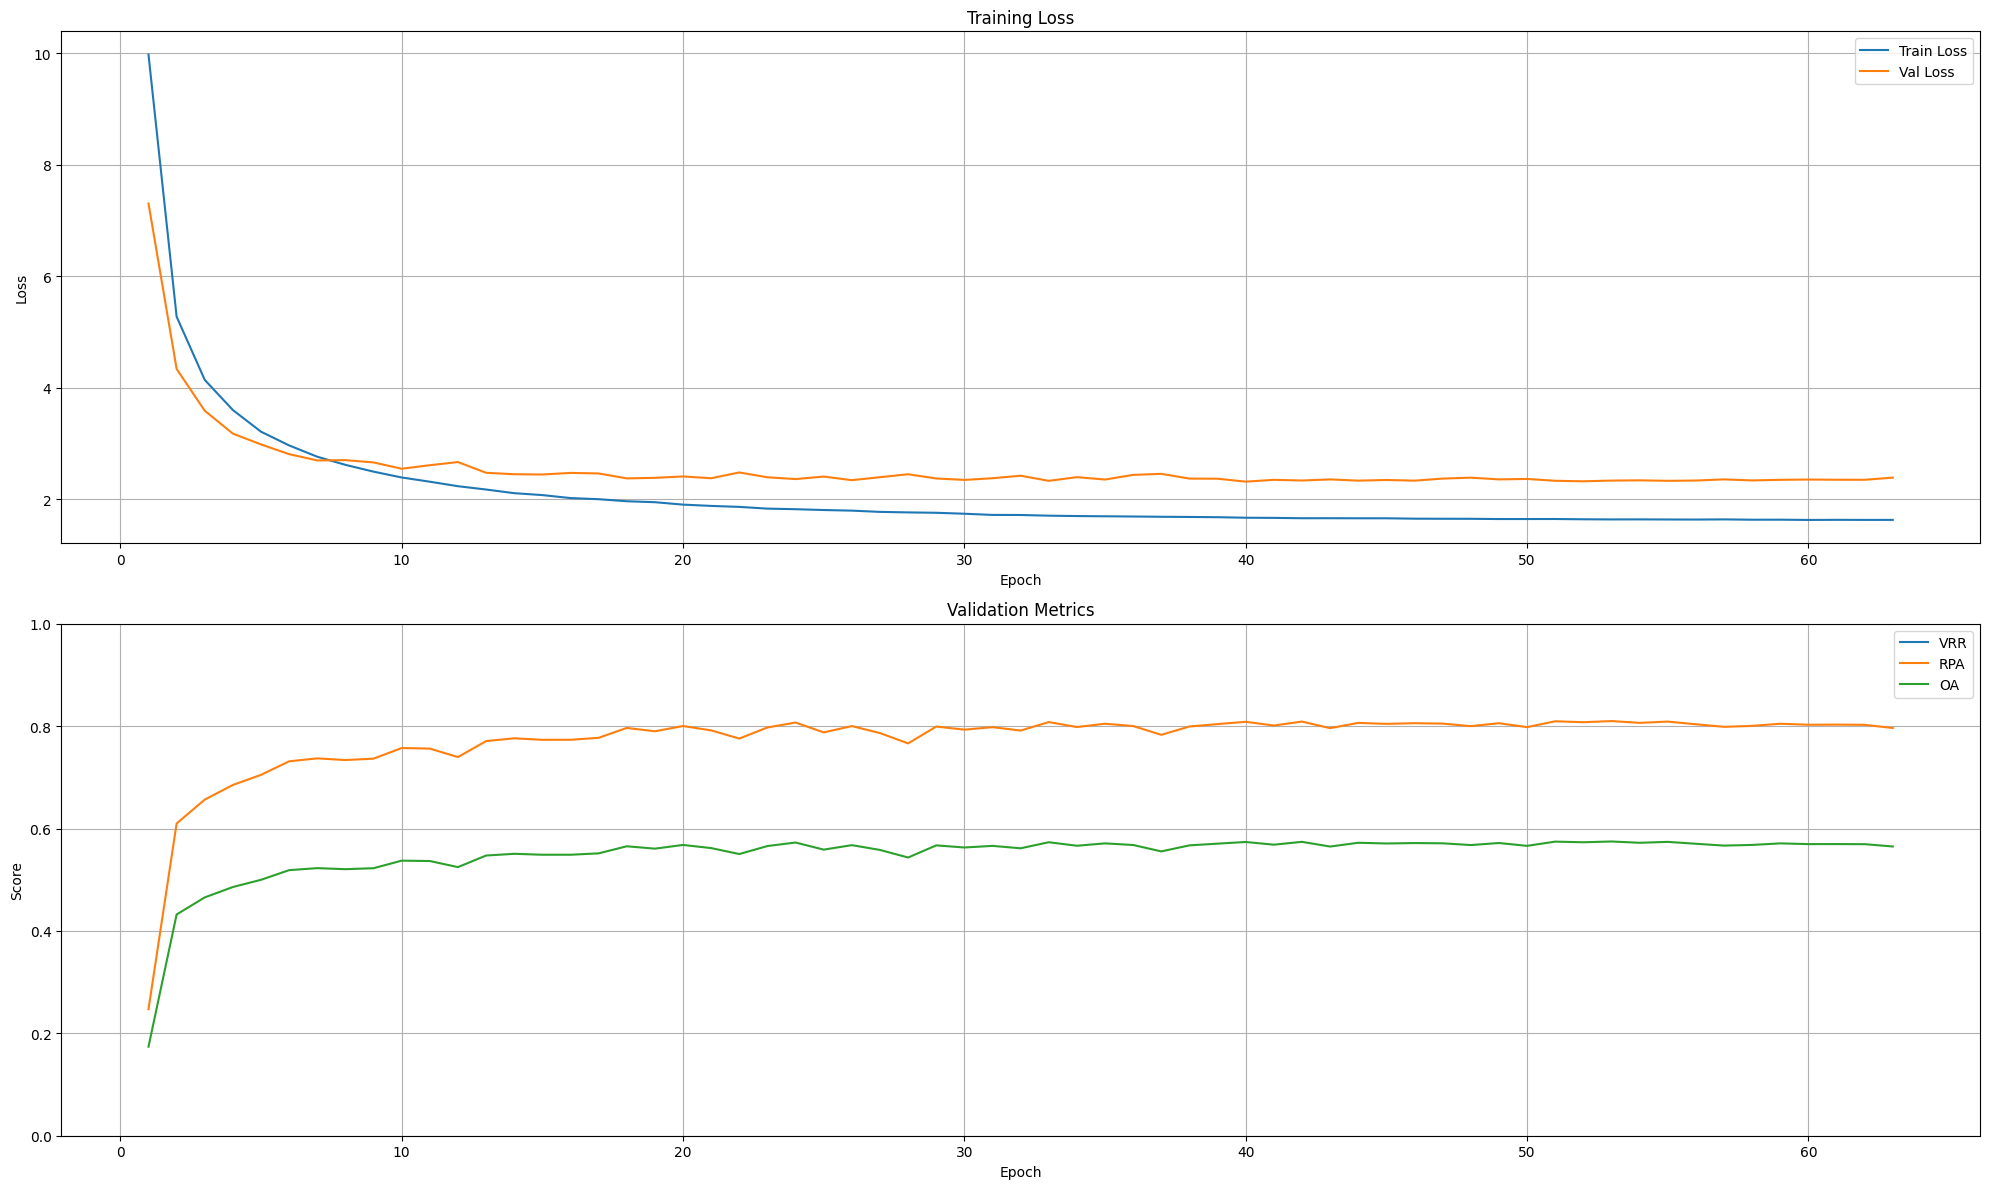

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(20, 12))

# ---- Loss ----
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

# ---- Metrics ----
plt.subplot(2, 1, 2)
plt.plot(epochs, val_vrrs, label="VRR")
plt.plot(epochs, val_rpas, label="RPA")
plt.plot(epochs, val_oas, label="OA")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics")
plt.ylim(0,1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("checkpoints/model_Toeplitz_FC_RRCGDNet_UNet_fs_by_4/pitch_smoothed_CE_loss_best_oa/training_curves.png", dpi=200)  # SAVE FIRST
plt.show()
plt.close()


In [151]:
import numpy as np

def ema(x, alpha=0.3):
    y = np.zeros_like(x, dtype=float)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1 - alpha) * y[i-1]
    return y


In [152]:
train_losses_s = ema(train_losses, alpha=0.3)
val_losses_s   = ema(val_losses, alpha=0.3)

val_vrrs_s = ema(val_vrrs, alpha=0.3)
val_rpas_s = ema(val_rpas, alpha=0.3)
val_oas_s  = ema(val_oas,  alpha=0.3)

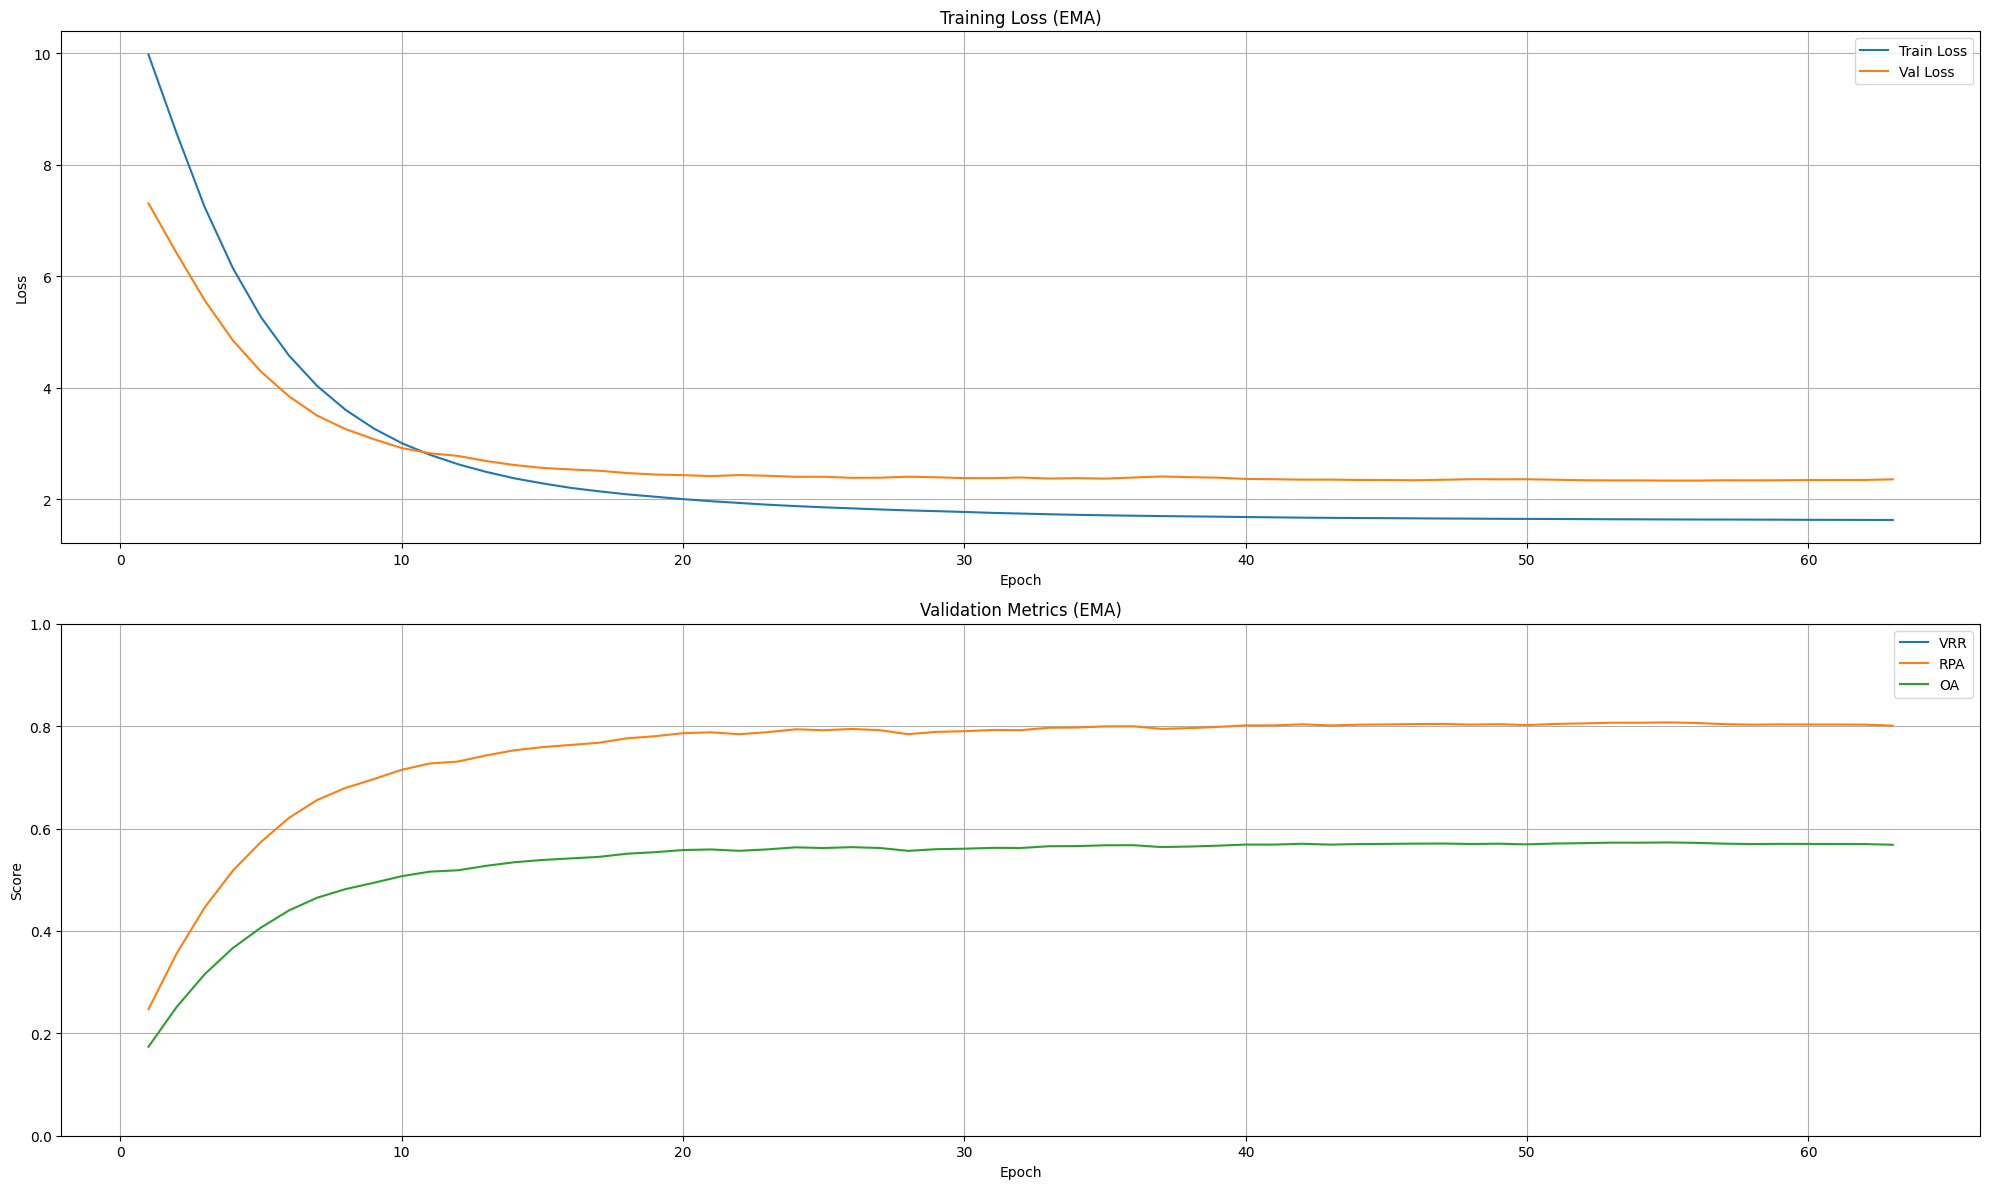

In [153]:
epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(20,12))

# ---- Loss ----
plt.subplot(2,1,1)
plt.plot(epochs, ema(train_losses, 0.3), label="Train Loss")
plt.plot(epochs, ema(val_losses, 0.3), label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (EMA)")
plt.grid(True)
plt.legend()

# ---- Metrics ----
plt.subplot(2,1,2)
plt.plot(epochs, ema(val_vrrs, 0.3), label="VRR")
plt.plot(epochs, ema(val_rpas, 0.3), label="RPA")
plt.plot(epochs, ema(val_oas,  0.3), label="OA")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.title("Validation Metrics (EMA)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("checkpoints/model_Toeplitz_FC_RRCGDNet_UNet_fs_by_4/pitch_smoothed_CE_loss_best_oa/smooth_training_curves.png", dpi=200)
plt.show()
plt.close()


In [154]:
metrics = evaluate_full(model, test_loader, device)

test_vrr = metrics["VRR"]
test_rpa = metrics["RPA"]
test_oa  = metrics["OA"]

print(
    f"[TEST] VRR={test_vrr:.3f} | "
    f"RPA={test_rpa:.3f} | OA={test_oa:.3f}"
)


[TEST] VRR=1.000 | RPA=0.912 | OA=0.643


In [155]:
def model_summary(model):
    total = 0
    for name, p in model.named_parameters():
        if p.requires_grad:
            total += p.numel()
    return total

n_params = model_summary(model)
print(f"Total trainable parameters: {n_params:,}")

with open("checkpoints/model_Toeplitz_FC_RRCGDNet_UNet_fs_by_4/pitch_smoothed_CE_loss_best_oa/model_stats.txt", "w") as f:
    f.write(f"Total trainable parameters: {n_params}\n")


Total trainable parameters: 24,656,336


In [156]:
import json
import os
from datetime import datetime

def save_test_results(
    test_vrr, test_rpa, test_oa,
    ckpt_dir="checkpoints/model_Toeplitz_FC_RRCGDNet_UNet_fs_by_4/pitch_smoothed_CE_loss_best_oa/"
):
    os.makedirs(ckpt_dir, exist_ok=True)

    results = {
        "timestamp": datetime.now().isoformat(),
        "VRR": test_vrr,
        "RPA": test_rpa,
        "OA": test_oa,
    }

    out_path = os.path.join(ckpt_dir, "test_results.json")
    with open(out_path, "w") as f:
        json.dump(results, f, indent=2)

    print(f"[LOGGED] Test results → {out_path}")


In [157]:
save_test_results(test_vrr, test_rpa, test_oa)

[LOGGED] Test results → checkpoints/model_Toeplitz_FC_RRCGDNet_UNet_fs_by_4/pitch_smoothed_CE_loss_best_oa/test_results.json


In [158]:
import torch

model.eval()

# unwrap DataParallel
export_model = model.module if isinstance(model, torch.nn.DataParallel) else model

dummy_input = torch.randn(1, 200, 256).to(device)  # (B,T,F) adjust T if needed

torch.onnx.export(
    export_model,
    dummy_input,
    "checkpoints/model_Toeplitz_FC_RRCGDNet_UNet_fs_by_4/pitch_smoothed_CE_loss_best_oa/model.onnx",
    input_names=["rrcgd"],
    output_names=["logits"],
    dynamic_axes={
        "rrcgd": {1: "time"},
        "logits": {1: "time"}
    },
    opset_version=14
)


/tmp/ipykernel_1208299/2486459275.py:23: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert D == self.in_dim
/home/batch_2024/ee24s004/miniconda3/envs/gd_exps/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:4661: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


TypeError: z_(): incompatible function arguments. The following argument types are supported:
    1. (self: torch._C.Node, arg0: str, arg1: torch.Tensor) -> torch._C.Node

Invoked with: %608 : Tensor = onnx::Constant(), scope: __main__.Toeplitz_FC_RRCGDNet_UNet::/__main__.ToeplitzPitchHead::fc
, 'value', <TensorProtoDataType.BOOL: 9> 
(Occurred when translating unfold).

In [159]:
model.eval()

export_model = model.module if isinstance(model, torch.nn.DataParallel) else model
export_model = export_model.to("cpu")   # safer for scripting

scripted = torch.jit.script(export_model)
scripted.save("checkpoints/model_Toeplitz_FC_RRCGDNet_UNet_fs_by_4/pitch_smoothed_CE_loss_best_oa/model_torchscript.pt")

In [160]:
# !pip install torchinfo

In [161]:
from torchinfo import summary

summary(
    export_model,
    input_size=(1, 200, 256),  # (B,T,F)
    col_names=["input_size", "output_size", "num_params"],
    depth=4
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Toeplitz_FC_RRCGDNet_UNet                [1, 200, 256]             [1, 200, 360]             --
├─Down: 1-1                              [1, 1, 256, 200]          [1, 64, 256, 200]         --
│    └─ConvBlock: 2-1                    [1, 1, 256, 200]          [1, 64, 256, 200]         --
│    │    └─Sequential: 3-1              [1, 1, 256, 200]          [1, 64, 256, 200]         --
│    │    │    └─Conv2d: 4-1             [1, 1, 256, 200]          [1, 64, 256, 200]         640
│    │    │    └─BatchNorm2d: 4-2        [1, 64, 256, 200]         [1, 64, 256, 200]         128
│    │    │    └─ReLU: 4-3               [1, 64, 256, 200]         [1, 64, 256, 200]         --
│    │    │    └─Conv2d: 4-4             [1, 64, 256, 200]         [1, 64, 256, 200]         36,928
│    │    │    └─BatchNorm2d: 4-5        [1, 64, 256, 200]         [1, 64, 256, 200]         128
│    │    │    └─ReLU: 4-6  

In [162]:
with open("checkpoints/model_Toeplitz_FC_RRCGDNet_UNet_fs_by_4/pitch_smoothed_CE_loss_best_oa/summary.txt", "w") as f:
    f.write(str(summary(export_model, input_size=(1,200,256))))


In [163]:
import numpy as np
import torch

def evaluate_voicing(model, loader, device):
    model.eval()

    TP = FP = FN = TN = 0

    with torch.no_grad():
        for X, Y, _, lengths in loader:
            X = X.to(device)
            Y = Y.to(device)

            logits = model(X)
            preds = torch.argmax(logits, dim=-1)

            B = X.shape[0]

            for b in range(B):
                T = lengths[b].item()

                gt_bins   = Y[b, :T].cpu().numpy()
                pred_bins = preds[b, :T].cpu().numpy()

                gt_voiced   = gt_bins > 0
                pred_voiced = pred_bins > 0

                TP += np.sum(pred_voiced & gt_voiced)
                FP += np.sum(pred_voiced & ~gt_voiced)
                FN += np.sum(~pred_voiced & gt_voiced)
                TN += np.sum(~pred_voiced & ~gt_voiced)

    precision = TP / (TP + FP + 1e-8)
    recall    = TP / (TP + FN + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    return {
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "TN": TN,
    }

In [164]:
import matplotlib.pyplot as plt

def plot_voicing_confusion_matrix(cm, normalize=True):
    """
    cm: 2x2 confusion matrix
    normalize: show percentages instead of counts
    """
    if normalize:
        cm = cm / (cm.sum(axis=1, keepdims=True) + 1e-8)

    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Unvoiced", "Voiced"])
    ax.set_yticklabels(["Unvoiced", "Voiced"])

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Ground Truth")
    ax.set_title("Voicing Confusion Matrix")

    for i in range(2):
        for j in range(2):
            val = cm[i, j]
            txt = f"{val:.2f}" if normalize else f"{int(val)}"
            ax.text(j, i, txt, ha="center", va="center")

    plt.tight_layout()
    plt.show()


In [165]:
import numpy as np

def voicing_confusion_matrix(voicing_metrics):
    TP = voicing_metrics["TP"]
    FP = voicing_metrics["FP"]
    FN = voicing_metrics["FN"]
    TN = voicing_metrics["TN"]

    # rows = ground truth, cols = prediction
    return np.array([
        [TN, FP],
        [FN, TP]
    ])


[VOICING] Precision=0.712 | Recall=1.000 | F1=0.832
Confusion: TP=30916 | FP=12517 | FN=0 | TN=0


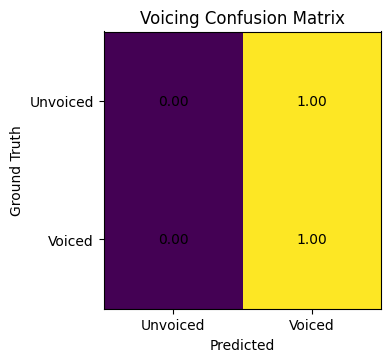

In [166]:
voicing_metrics = evaluate_voicing(model, test_loader, device)

print(
    f"[VOICING] "
    f"Precision={voicing_metrics['Precision']:.3f} | "
    f"Recall={voicing_metrics['Recall']:.3f} | "
    f"F1={voicing_metrics['F1']:.3f}"
)

print(
    f"Confusion: "
    f"TP={voicing_metrics['TP']} | "
    f"FP={voicing_metrics['FP']} | "
    f"FN={voicing_metrics['FN']} | "
    f"TN={voicing_metrics['TN']}"
)

cm = voicing_confusion_matrix(voicing_metrics)

plot_voicing_confusion_matrix(cm, normalize=True)

In [167]:
def plot_voicing_scores(voicing_metrics):
    labels = ["Precision", "Recall", "F1"]
    values = [
        voicing_metrics["Precision"],
        voicing_metrics["Recall"],
        voicing_metrics["F1"],
    ]

    plt.figure(figsize=(4, 3))
    plt.bar(labels, values)
    plt.ylim(0, 1)
    plt.title("Voicing Metrics")
    plt.show()

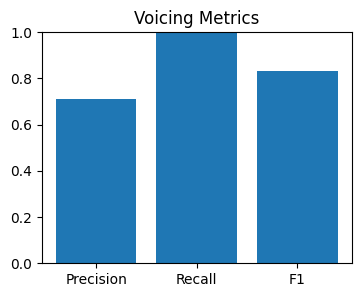

In [168]:
plot_voicing_scores(voicing_metrics)

In [169]:
def save_voicing_metrics(voicing_metrics, out_path):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with open(out_path, "w") as f:
        json.dump(voicing_metrics, f, indent=4)

In [170]:
import os

def save_voicing_metrics_txt(voicing_metrics, out_path):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    with open(out_path, "w") as f:
        f.write("Voicing metrics\n")
        f.write("================\n")
        f.write(f"Precision : {float(voicing_metrics['Precision']):.6f}\n")
        f.write(f"Recall    : {float(voicing_metrics['Recall']):.6f}\n")
        f.write(f"F1-score  : {float(voicing_metrics['F1']):.6f}\n")
        f.write("\nConfusion matrix counts\n")
        f.write("-----------------------\n")
        f.write(f"TP : {int(voicing_metrics['TP'])}\n")
        f.write(f"FP : {int(voicing_metrics['FP'])}\n")
        f.write(f"FN : {int(voicing_metrics['FN'])}\n")
        f.write(f"TN : {int(voicing_metrics['TN'])}\n")

In [171]:
voicing_metrics = evaluate_voicing(model, test_loader, device)

save_voicing_metrics_txt(
    voicing_metrics,
    "checkpoints/model_Toeplitz_FC_RRCGDNet_UNet_fs_by_4/pitch_smoothed_CE_loss_best_oa/voicing_metrics_test.txt"
)
